In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('ecommerce_dataset.csv')

# Display the first few rows to get a sense of the data
print(df.head())

   order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2425083    49125             1          2                 18   
1   2425083    49125             1          2                 18   
2   2425083    49125             1          2                 18   
3   2425083    49125             1          2                 18   
4   2425083    49125             1          2                 18   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN          17                  1          0   
1                     NaN          91                  2          0   
2                     NaN          36                  3          0   
3                     NaN          83                  4          0   
4                     NaN          83                  5          0   

   department_id  department        product_name  
0             13      pantry  baking ingredients  
1             16  dairy eggs     soy lactosefree  
2          

In [2]:
# Fill missing values in 'days_since_prior_order' with 0
df['days_since_prior_order'].fillna(0, inplace=True)

# Verify the change
print(df.isnull().sum())

order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
department                0
product_name              0
dtype: int64


In [3]:
# Aggregate data to calculate RFM values for each customer
rfm = df.groupby('user_id').agg({
    'days_since_prior_order': 'min',  # Recency
    'order_id': 'nunique',            # Frequency
    'product_id': 'count'             # Monetary (using the count of products as a proxy for spending)
}).reset_index()

# Rename columns for clarity
rfm.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']

# Inspect the resulting RFM DataFrame
print(rfm.head())

   user_id  Recency  Frequency  Monetary
0        2      3.0          2        11
1        3      9.0          3        19
2        7     30.0          1        24
3       10     14.0          1        30
4       11     30.0          1        11


In [11]:
# Recalculate RFM Scores to ensure they are simple concatenations
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=False, duplicates='drop')
rfm['F_score'] = pd.qcut(rfm['Frequency'], 5, labels=False, duplicates='drop')
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=False, duplicates='drop')

# Combine the RFM scores into a single string
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Check the result
print(rfm[['R_score', 'F_score', 'M_score', 'RFM_Score']].head())


   R_score  F_score  M_score RFM_Score
0        1        0        2       102
1        3        1        3       313
2        4        0        3       403
3        3        0        4       304
4        4        0        2       402


In [14]:
# Check the data types of the R, F, M scores
print(rfm[['R_score', 'F_score', 'M_score']].dtypes)

R_score    int64
F_score    int64
M_score    int64
dtype: object


In [16]:
# Print some of the data to check the scores before concatenation
print(rfm[['user_id', 'R_score', 'F_score', 'M_score']].head(10))

   user_id  R_score  F_score  M_score
0        2        1        0        2
1        3        3        1        3
2        7        4        0        3
3       10        3        0        4
4       11        4        0        2
5       13        2        0        1
6       17        1        0        0
7       21        3        0        0
8       22        1        0        1
9       24        4        0        0


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Use the original Recency, Frequency, and Monetary values
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Inspect the clusters by checking the mean values for each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'user_id': 'count'
}).reset_index()

print(cluster_summary)

   Cluster    Recency  Frequency   Monetary  user_id
0        0   5.975552   1.328299  11.037470    53296
1        1   4.162098   3.103121  32.780338    22653
2        2  25.951694   1.112053  10.971227    23703
3        3   2.505960   5.791318  76.254047     5621


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

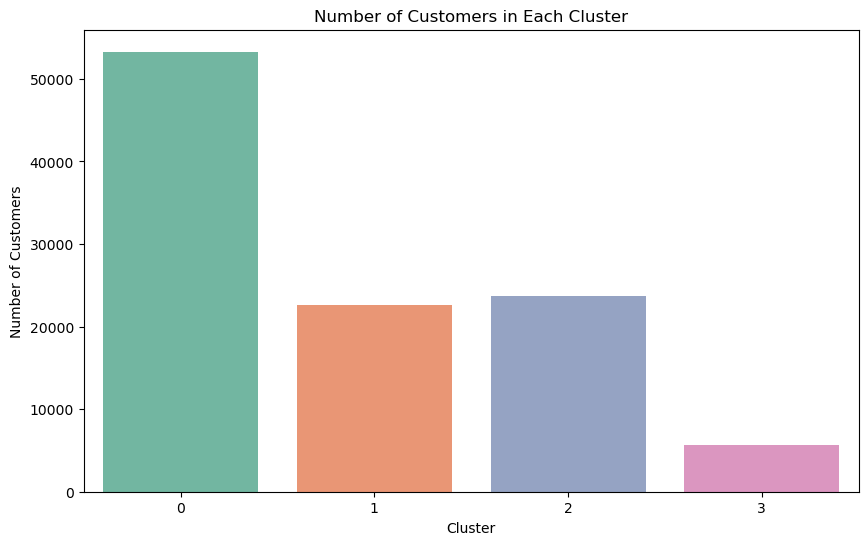

In [19]:
# Plot the distribution of customers across clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=rfm, palette='Set2')
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

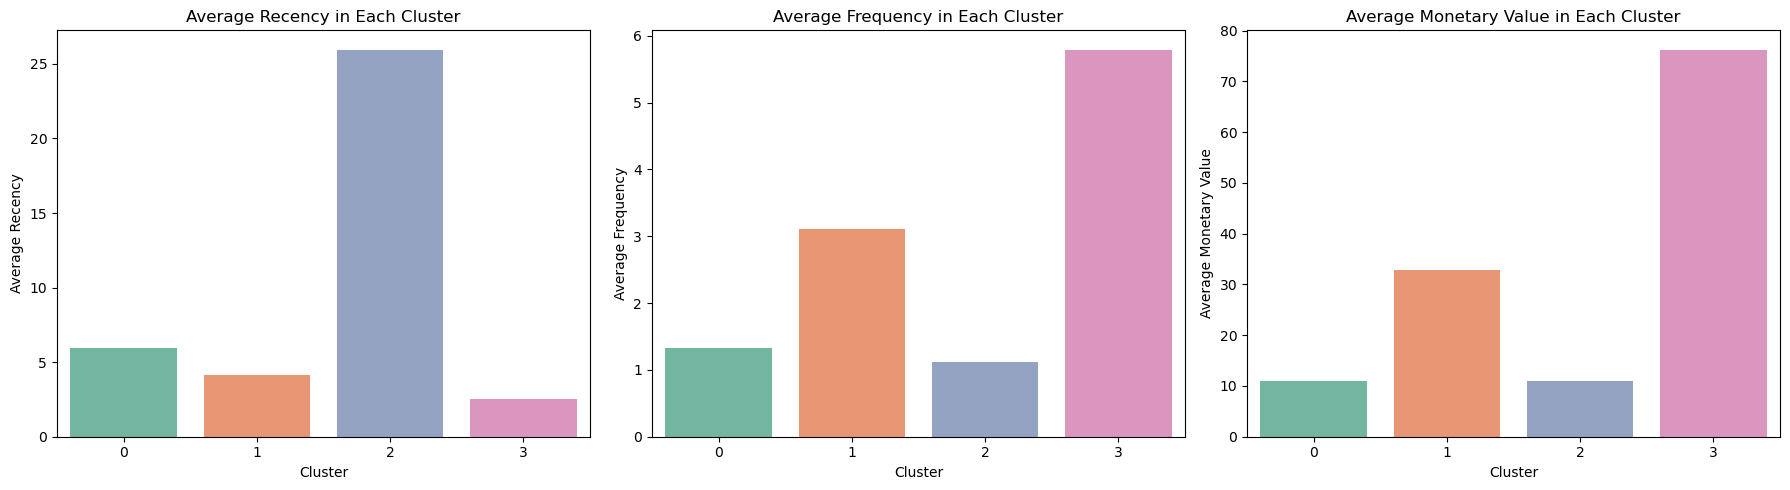

In [20]:
# Set up the figure
plt.figure(figsize=(18, 5))

# Plot for Recency
plt.subplot(1, 3, 1)
sns.barplot(x='Cluster', y='Recency', data=cluster_summary, palette='Set2')
plt.title('Average Recency in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')

# Plot for Frequency
plt.subplot(1, 3, 2)
sns.barplot(x='Cluster', y='Frequency', data=cluster_summary, palette='Set2')
plt.title('Average Frequency in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Frequency')

# Plot for Monetary
plt.subplot(1, 3, 3)
sns.barplot(x='Cluster', y='Monetary', data=cluster_summary, palette='Set2')
plt.title('Average Monetary Value in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Monetary Value')

plt.tight_layout()
plt.show()

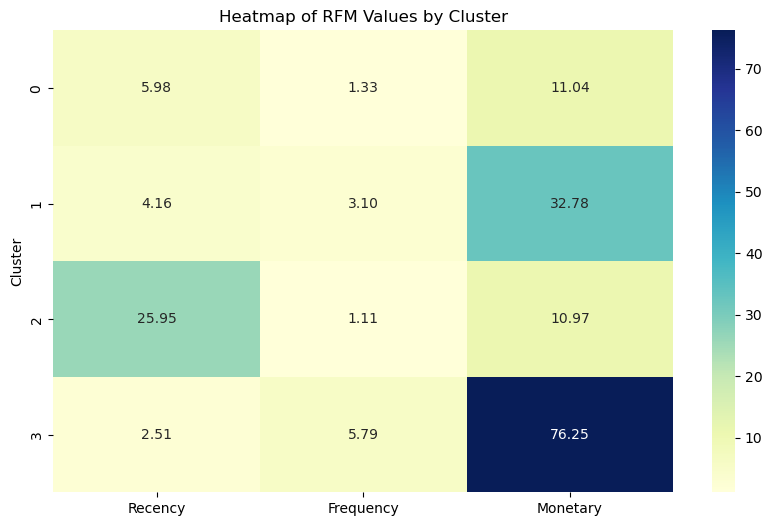

In [21]:
# Prepare data for heatmap
heatmap_data = cluster_summary.set_index('Cluster')[['Recency', 'Frequency', 'Monetary']]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Heatmap of RFM Values by Cluster')
plt.show()

C:\Users\91720\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


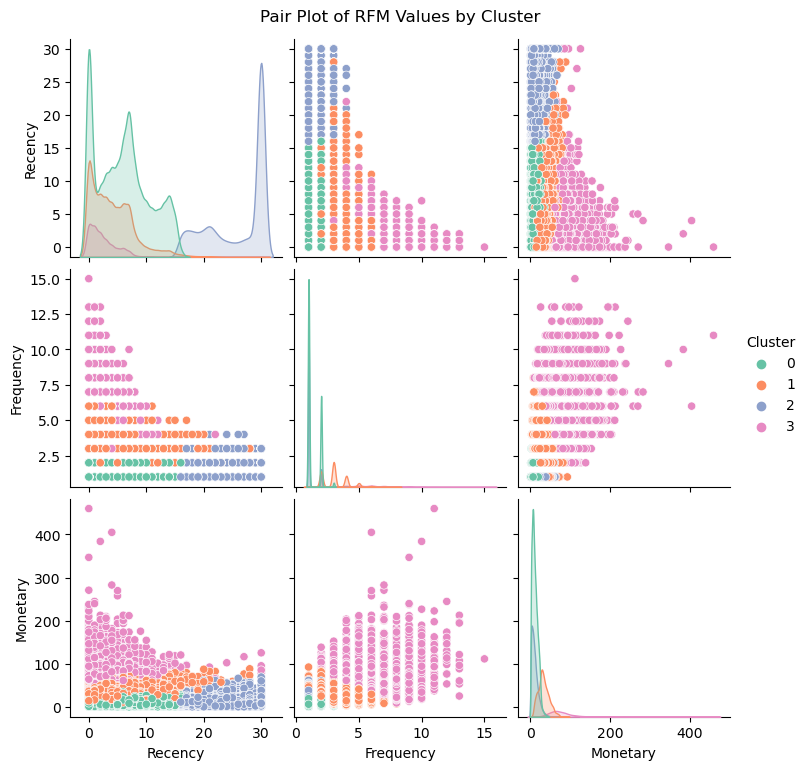

In [22]:
# Pair plot for RFM values colored by Cluster
sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='Set2')
plt.suptitle('Pair Plot of RFM Values by Cluster', y=1.02)
plt.show()

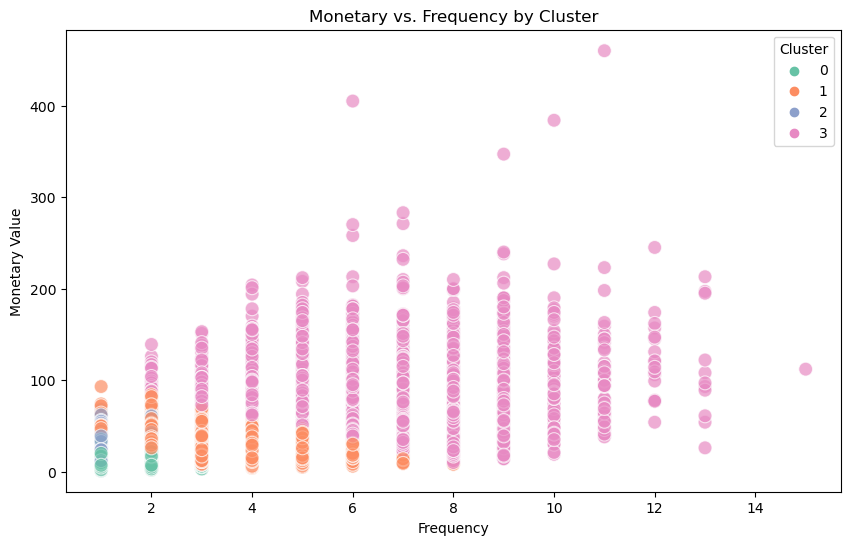

In [23]:
# Scatter plot of Monetary vs Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='Set2', s=100, alpha=0.7)
plt.title('Monetary vs. Frequency by Cluster')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.show()